In [1]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision

print(torchvision.__version__)

from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

import torchvision.transforms.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms.functional import convert_image_dtype

from PIL import Image
import copy

0.8.2


In [ ]:
def permute_and_flatten(layer, N, A, C, H, W):
    # type: (Tensor, int, int, int, int, int) -> Tensor
    layer = layer.view(N, -1, C, H, W)
    layer = layer.permute(0, 3, 4, 1, 2)
    layer = layer.reshape(N, -1, C)
    return layer

def concat_box_prediction_layers(box_cls, box_regression):
    # type: (List[Tensor], List[Tensor]) -> Tuple[Tensor, Tensor]
    box_cls_flattened = []
    box_regression_flattened = []
    # for each feature level, permute the outputs to make them be in the
    # same format as the labels. Note that the labels are computed for
    # all feature levels concatenated, so we keep the same representation
    # for the objectness and the box_regression
    for box_cls_per_level, box_regression_per_level in zip(
        box_cls, box_regression
    ):
        N, AxC, H, W = box_cls_per_level.shape
        Ax4 = box_regression_per_level.shape[1]
        A = Ax4 // 4
        C = AxC // A
        box_cls_per_level = permute_and_flatten(
            box_cls_per_level, N, A, C, H, W
        )
        box_cls_flattened.append(box_cls_per_level)

        box_regression_per_level = permute_and_flatten(
            box_regression_per_level, N, A, 4, H, W
        )
        box_regression_flattened.append(box_regression_per_level)
    # concatenate on the first dimension (representing the feature levels), to
    # take into account the way the labels were generated (with all feature maps
    # being concatenated as well)
    box_cls = torch.cat(box_cls_flattened, dim=1).flatten(0, -2)
    box_regression = torch.cat(box_regression_flattened, dim=1).reshape(-1, 4)
    return box_cls, box_regression

In [44]:
plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs, bboxs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        for bbox in bboxs:
            colors = np.random.randint(0, 255, [1, 3])[0]/255
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                     linewidth=1, edgecolor=colors, facecolor='none')
            axs[0, i].add_patch(rect)
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


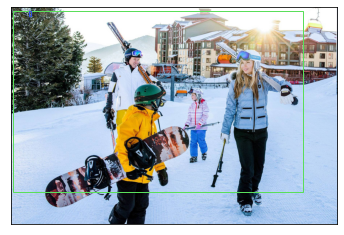

In [45]:
path_asset = Path("/home/ameyer/Images/sample_imagenet")
dog1_int = read_image(str(path_asset / 'fox.jpg'))
dog2_int = read_image(str(path_asset / 'elephant.jpg'))
skii_int = read_image(str(path_asset / 'famskiin.jpg'))

grid = make_grid([skii_int])
show(grid, [[10, 20, 1600, 1000], [100, 20, 10, 30]])


In [4]:
batch_int = torch.stack([skii_int, skii_int])
print(batch_int.shape)
batch = convert_image_dtype(batch_int, dtype=torch.float)

model = fasterrcnn_resnet50_fpn(pretrained=True, progress=False, min_size=800, max_size=800)
model = model.eval()

torch.Size([2, 3, 1200, 1800])


In [ ]:
model

In [ ]:
model.rpn.head.bbox_pred, model.rpn.head.cls_logits

In [ ]:
p_in = []
p_out = []

# Define hook_fn
def hook_fn(module, inputs, outputs):
    p_in.append(inputs)
    p_out.append(outputs)

In [ ]:
# The results of the middle layer are stored at will, and hook_fn needs to be "hooked" to the "target layer"
model.rpn.register_forward_hook(hook_fn)

In [ ]:
activation = {}
activation2 = {}
def get_activation2(name1, name2):
    def hook(model, input, output):
        activation2[name1] = output[0]
        activation2[name2] = output[1]
    return hook

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
#model.rpn.register_forward_hook(get_activation('bbox_pred'))
model.rpn.head.cls_logits.register_forward_hook(get_activation('cls_logits'))
model.rpn.head.bbox_pred.register_forward_hook(get_activation('bbox_pred'))
model.rpn.register_forward_hook(get_activation2('rpn_boxes', 'rpn_losses'))

In [ ]:
outputs = model(batch)
print(outputs)

In [ ]:
score_threshold = .5
dogs_with_boxes = [
    show(dog_int, output['boxes'][output['scores'] > score_threshold])
    for dog_int, output in zip(batch_int, outputs)
]

In [ ]:
activation['bbox_pred'][0].shape

In [ ]:
torch.sigmoid(activation['cls_logits'])[0][:, 1, 1] > 0.5

In [ ]:
((4, 5, 12), ) * 5

In [ ]:
model.rpn.filter_proposals

In [ ]:
model

In [ ]:
activation2

In [ ]:
p_in[0][1]

In [ ]:
# the hook gave us a list of all input and all output
# they are themself stocked in a list
# in our case, we have 3 input and one output

# p_in[0][0] --> ImageList: image
# p_in[0][1] --> OrderedDict: features
# p_in[0][1] --> targets (None in inf)

# p_out[0][0][0] --> tensor for batch 0: 1000 best boxes 
# p_out[0][1] --> Dict: loss (empty in inf)

len(p_in)

In [ ]:
p_in[0][0]

In [ ]:
for k, v in p_in[0][1].items():
    print(k)

In [ ]:
p_in[0][2]
# empty

In [ ]:
p_in[0][0]

In [ ]:
len(p_out[0][0])

In [ ]:
p_out[0][1]

In [ ]:
images = p_in[0][0]
features = p_in[0][1]

features = list(p_in[0][1].values())
objectness, pred_bbox_deltas = model.rpn.head(features)
anchors = model.rpn.anchor_generator(images, features)


num_images = len(anchors)
num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]

objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)

proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
proposals = proposals.view(num_images, -1, 4)
boxes, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

In [ ]:
boxes[0].shape

In [ ]:
scores[0].shape

In [ ]:
type(boxes[0])

In [ ]:
# convert to proba
scores[0] = torch.sigmoid(scores[0])

In [ ]:
boxes[0]

In [ ]:
# resize image and draw proposal
def resize_boxes(boxes, original_size, new_size):
    ratios = [ns/os for ns, os in zip(new_size, original_size)]
    ratio_height, ratio_width = ratios
    xmin, ymin, xmax, ymax = boxes
    
    xmin = xmin * ratio_width
    xmax = xmax * ratio_width
    ymin = ymin * ratio_height
    ymax = ymax * ratio_height
    return torch.tensor([xmin, ymin, xmax, ymax])

    
bbox_pos = torch.stack([bbox for (bbox, score) in zip(boxes[0], scores[0]) if score > 0.5])
score_pos = torch.stack([score for score in scores[0] if score > 0.5])

out = torch.stack([resize_boxes(bbox, (800, 800), (1800, 1200)) for bbox in bbox_pos])
#out = resize_boxes(boxes[0][0], (800, 800), (320, 240))
print(out)

out2 = torchvision.ops.nms(out, score_pos, 0.3)

print(out2.shape)

In [ ]:
torch.stack(bbox_pos)

In [ ]:
pred_rpn_with_nms = torch.index_select(torch.as_tensor(bbox_pos), 0, out2)

In [ ]:
show(grid, pred_rpn_with_nms)

In [ ]:
# Take the P2 level as an example, first pass cls_logits through the sigmoid function to get a value between 0-1
p2_logits = torch.sigmoid(p_out[3])
p2_logits = p2_logits.detach().numpy()  # Convert to numpy array
# Remove the value less than 0, this practice refers to the practice of the score cam article
p2_logits = np.maximum(p2_logits, 0)
# Normalized
p2_logits = (p2_logits - np.min(p2_logits))/(np.max(p2_logits)-np.min(p2_logits))
# Convert to uint8 type
p2_logits = np.uint8(p2_logits * 255)
# Take one of the channels
p2_logits = p2_logits[0, 0, ...]
# Zoom to the original image size, my original image size is 2048*2048
p2_logits = np.uint8(Image.fromarray(p2_logits).resize((320, 240), Image.ANTIALIAS)) / 255


In [ ]:
plt.imshow(p2_logits)

In [ ]:
def put_heatmap_on_image(ori_image, activation, colormap_name):
    """
         ori_image (PIL image): original image
         activation (numpy arr): p2_logits obtained above
         colormap_name (str): What colormap of matplotlib.cm is used
    """
    # colormap
    color_map = matplotlib.cm.get_cmap(colormap_name)
    # Add the colormap to activation, which is the activation
    # colormap to display
    no_trans_heatmap = color_map(activation)
    # Add alpha channel, which is transparency
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))
    # Overwrite the heat map to the original image
    heatmap_on_image = Image.new("RGBA", ori_image.size)
    heatmap_on_image = Image.alpha_composite(
                        heatmap_on_image, ori_image.convert("RGBA"))
    heatmap_on_image = Image.alpha_composite(
                        heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image

In [ ]:
dog1_int.detach().numpy().shape

In [ ]:
img = Image.fromarray(np.rollaxis(dog1_int.detach().numpy(), 0,3))
heatmap, heatmap_on_image = put_heatmap_on_image(
            img, p2_logits, "jet")
#heatmap_on_image.save("xxx.png")

In [ ]:
heatmap

In [ ]:
heatmap_on_image

In [ ]:
anchor_gen = model.rpn.anchor_generator

In [ ]:
anchors = anchor_gen(batch_int, p_in)

In [ ]:
p_in[0][0].shape

In [ ]:
p_in

In [46]:
# resize box to target image size
def resize_boxes(boxes, original_size, new_size):
    ratios = [ns/os for ns, os in zip(new_size, original_size)]
    ratio_height, ratio_width = ratios
    xmin, ymin, xmax, ymax = boxes
    
    xmin = xmin * ratio_width
    xmax = xmax * ratio_width
    ymin = ymin * ratio_height
    ymax = ymax * ratio_height
    return torch.tensor([xmin, ymin, xmax, ymax])

def permute_and_flatten(layer, N, A, C, H, W):
    # type: (Tensor, int, int, int, int, int) -> Tensor
    layer = layer.view(N, -1, C, H, W)
    layer = layer.permute(0, 3, 4, 1, 2)
    layer = layer.reshape(N, -1, C)
    return layer

def concat_box_prediction_layers(box_cls, box_regression):
    # type: (List[Tensor], List[Tensor]) -> Tuple[Tensor, Tensor]
    box_cls_flattened = []
    box_regression_flattened = []
    # for each feature level, permute the outputs to make them be in the
    # same format as the labels. Note that the labels are computed for
    # all feature levels concatenated, so we keep the same representation
    # for the objectness and the box_regression
    for box_cls_per_level, box_regression_per_level in zip(
        box_cls, box_regression
    ):
        N, AxC, H, W = box_cls_per_level.shape
        Ax4 = box_regression_per_level.shape[1]
        A = Ax4 // 4
        C = AxC // A
        box_cls_per_level = permute_and_flatten(
            box_cls_per_level, N, A, C, H, W
        )
        box_cls_flattened.append(box_cls_per_level)

        box_regression_per_level = permute_and_flatten(
            box_regression_per_level, N, A, 4, H, W
        )
        box_regression_flattened.append(box_regression_per_level)
    # concatenate on the first dimension (representing the feature levels), to
    # take into account the way the labels were generated (with all feature maps
    # being concatenated as well)
    box_cls = torch.cat(box_cls_flattened, dim=1).flatten(0, -2)
    box_regression = torch.cat(box_regression_flattened, dim=1).reshape(-1, 4)
    return box_cls, box_regression

p_in = []
p_out = []

# Define hook_fn
def hook_fn(module, inputs, outputs):
    p_in.append(inputs)
    p_out.append(outputs)

def get_RPN_prediction(model, model_input,
                       size_resised_input_img=(800, 800), size_input_img=(1800, 1200),
                       score_threshold=0.5,
                       nms_overlaps_threshold=0.3):
    # place an hook on the rpn to capture i/o
    model.rpn.register_forward_hook(hook_fn)
    
    # the hook gave us a list of all input and all output
    # they are themself stocked in a list
    # in our case, we have 3 input and one output

    # p_in[0][0] --> ImageList: image
    # p_in[0][1] --> OrderedDict: features
    # p_in[0][1] --> targets (None in inf)

    # p_out[0][0][0] --> tensor for batch 0: 1000 best boxes 
    # p_out[0][1] --> Dict: loss (empty in inf)
    
    # predict with model
    outputs = model(model_input)
    
    images = p_in[0][0]
    features = p_in[0][1]

    features = list(p_in[0][1].values())
    objectness, pred_bbox_deltas = model.rpn.head(features)
    anchors = model.rpn.anchor_generator(images, features)


    num_images = len(anchors)
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]

    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)

    # apply pred_bbox_deltas to anchors to obtain the decoded proposals
    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    boxes, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)
    
    # convert to proba
    scores[0] = torch.sigmoid(scores[0])

    bbox_pos = torch.stack([bbox for (bbox, score) in zip(boxes[0], scores[0]) if score > score_threshold])
    
    print(bbox_pos.shape)
    
    score_pos = torch.stack([score for score in scores[0] if score > score_threshold])
    
    print(score_pos.shape)

    resized_output_img = torch.stack([resize_boxes(bbox, size_resised_input_img, size_input_img)
                                      for bbox in bbox_pos])
    index_nms = torchvision.ops.nms(resized_output_img, score_pos, nms_overlaps_threshold)
    
    predictions = torch.index_select(resized_output_img, 0, index_nms)
    
    return resized_output_img, score_pos

    for score, bbox in zip(score_pos, resized_output_img):
        print(score, bbox)
        
    print(predictions)
    print(index_nms)
    
    show(grid, predictions)

In [47]:
get_RPN_prediction(model, batch, score_threshold=0.3, nms_overlaps_threshold=0.01)

torch.Size([958, 4])
torch.Size([958])
tensor(1.0000) tensor([ 359.0109,  396.4752,  593.9894, 1183.2220])
tensor(0.9999) tensor([ 767.7585,  240.5999, 1046.7578, 1128.9679])
tensor(0.9998) tensor([1037.1902,  409.2593, 1053.6633,  431.3828])
tensor(0.9998) tensor([633.1646, 437.7865, 729.2911, 871.4023])
tensor(0.9998) tensor([1036.9381,  408.1444, 1050.1550,  429.1064])
tensor(0.9997) tensor([1043.3081,  408.1876, 1059.7561,  431.9383])
tensor(0.9997) tensor([350.3684, 211.1992, 548.2435, 575.7644])
tensor(0.9997) tensor([350.8140, 218.5450, 508.5529, 743.7076])
tensor(0.9997) tensor([1033.9500,  405.2607, 1046.7170,  427.5536])
tensor(0.9996) tensor([1032.2042,  403.8706, 1044.9352,  426.6450])
tensor(0.9996) tensor([1035.5172,  404.4517, 1050.6375,  424.9013])
tensor(0.9996) tensor([1033.3152,  403.4804, 1047.6239,  423.2755])
tensor(0.9996) tensor([789.9135, 412.8189, 799.4156, 442.6715])
tensor(0.9996) tensor([1052.6178,  405.8654, 1068.6985,  431.9783])
tensor(0.9995) tensor([ 3